# Convolutional Neural Network

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## function for variables

In [2]:
def init_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.01))

## function for model construction

## tf.nn.conv2d(input, filter, strides, padding)
* input tensor shape: [batch, in_height, in_width, in_channels]
* filter tensor shape: [filter_height, filter_width, in_channels, out_channels]
* stride tensor: input의 각 dimension에 대한 sliding window의 stride
* padding: "SAME" or "Valid"

## tf.nn.max_pool(value, ksize, strides, padding)
* value: A 4-D Tensor with shape [batch, height, width, channels] and type tf.float32.
* ksize: A list of ints that has length >= 4. The size of the window for each dimension of the input tensor.
* strides: A list of ints that has length >= 4. The stride of the sliding window for each dimension of the input tensor.
* padding: "SAME" or "Valid"

## tf.nn.relu(features)
* max(features, 0)

## tf.nn.dropout(x, keep_prob)
* keep_prob: dropout probability

In [3]:
def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       
                        strides=[1, 1, 1, 1], padding='SAME'))
    # l1a output shape=(?, input_height, input_width, number_of_channels_layer1)
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              
                        strides=[1, 2, 2, 1], padding='SAME')
    # l1 output shape=(?, input_height/2, input_width/2, number_of_channels_layer1)
    l1 = tf.nn.dropout(l1, p_keep_conv)
    
    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     
                        strides=[1, 1, 1, 1], padding='SAME'))
    # l2a output shape=(?, input_height/2, input_width/2, number_of_channels_layer2)
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              
                        strides=[1, 2, 2, 1], padding='SAME')
    # l2 shape=(?, input_height/4, input_width/4, number_of_channels_layer2)
    l2 = tf.nn.dropout(l2, p_keep_conv)

    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     
                        strides=[1, 1, 1, 1], padding='SAME'))
    # l3a shape=(?, input_height/4, input_width/4, number_of_channels_layer3)
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              
                        strides=[1, 2, 2, 1], padding='SAME')
    # l3 shape=(?, input_height/8, input_width/8, number_of_channels_layer3)
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])
    # flatten to (?, input_height/8 * input_width/8 * number_of_channels_layer3)
    l3 = tf.nn.dropout(l3, p_keep_conv)

    l4 = tf.nn.relu(tf.matmul(l3, w4))
    #fully connected_layer
    l4 = tf.nn.dropout(l4, p_keep_hidden)
    
    pyx = tf.matmul(l4, w_o)
    return pyx


## Preparing data

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
X_trn, Y_trn, X_test, Y_test = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
X_trn = X_trn.reshape(-1, 28, 28, 1)  # 28x28x1 input img
X_test = X_test.reshape(-1, 28, 28, 1)  # 28x28x1 input img

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## make placeholder for inputs and labels

In [5]:
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y = tf.placeholder(tf.int32, [None])

## weight variable 와 Model 만들기
### convlution + max pooling layer
* 첫번째 convolution + max pooling layer: 3 X 3  Convolution, 2 * 2 max pooling, channel_in: 1, channel_out: 32
* 두번째 convolution + max pooling layer: 3 X 3  Convolution, 2 * 2 max pooling, channel_in: 32, channel_out: 64
* 세번째 convolution + max pooling layer: 3 X 3  Convolution, 2 * 2 max pooling, channel_in: 64, channel_out: 128

### fully connected layer
* flatten input layer to the fully connected layer
* hidden layer unit: 625
* output layer: number of classes (10)

### dropout
* convolution layer dropout
* fully connected layer dropout

In [6]:
w = init_weights([3, 3, 1, 32])       
w2 = init_weights([3, 3, 32, 64])     
w3 = init_weights([3, 3, 64, 128])    
w4 = init_weights([128 * 4 * 4, 625]) 
w_o = init_weights([625, 10])

p_keep_conv = tf.placeholder(tf.float32)
p_keep_hidden = tf.placeholder(tf.float32)
py_x = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

## loss function

In [7]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(py_x, Y))

## Training operator
#### tf.train.AdagradOptimizer

In [8]:
train_op = tf.train.AdagradOptimizer(learning_rate=0.05).minimize(loss)

## Accuracy 계산
### tensorflow를 통해서 accuracy를 계산

In [9]:
correct = tf.nn.in_top_k(py_x, Y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## Session initialize 및 training

In [10]:
trn_loss_list = list()
test_loss_list = list()
test_accuracy_list = list()
batch_size = 128
with tf.Session() as sess:    
    tf.initialize_all_variables().run()

    for i in range(50):
        trn_loss = 0
        for start, end in zip(range(0, len(X_trn), batch_size), range(batch_size, len(X_trn)+1, batch_size)):
            tmp_loss, _ = sess.run([loss, train_op], feed_dict={X: X_trn[start:end], Y: Y_trn[start:end],
                                         p_keep_conv: 1.0, p_keep_hidden: 0.8})
            trn_loss += tmp_loss
        trn_loss_list.append(trn_loss / (len(X_trn) // batch_size)
            
        test_loss, test_acc = sess.run([loss, accuracy], feed_dict={X: X_test, Y: Y_test,
                                                p_keep_conv: 1.0, p_keep_hidden: 1.0})
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_acc)
        print("epoch: {} test accuracy {:0.4f}".format(i, test_acc))

epoch: 0 test accuracy 0.1004
epoch: 1 test accuracy 0.0998
epoch: 2 test accuracy 0.0988
epoch: 3 test accuracy 0.0980
epoch: 4 test accuracy 0.8526
epoch: 5 test accuracy 0.9617
epoch: 6 test accuracy 0.9764
epoch: 7 test accuracy 0.9797
epoch: 8 test accuracy 0.9812
epoch: 9 test accuracy 0.9861
epoch: 10 test accuracy 0.9851
epoch: 11 test accuracy 0.9881
epoch: 12 test accuracy 0.9869
epoch: 13 test accuracy 0.9886
epoch: 14 test accuracy 0.9901
epoch: 15 test accuracy 0.9898
epoch: 16 test accuracy 0.9898
epoch: 17 test accuracy 0.9900
epoch: 18 test accuracy 0.9887
epoch: 19 test accuracy 0.9898
epoch: 20 test accuracy 0.9900
epoch: 21 test accuracy 0.9893
epoch: 22 test accuracy 0.9901
epoch: 23 test accuracy 0.9901
epoch: 24 test accuracy 0.9900
epoch: 25 test accuracy 0.9903
epoch: 26 test accuracy 0.9891
epoch: 27 test accuracy 0.9904
epoch: 28 test accuracy 0.9898
epoch: 29 test accuracy 0.9906
epoch: 30 test accuracy 0.9907
epoch: 31 test accuracy 0.9908
epoch: 32 test acc

## Loss plot

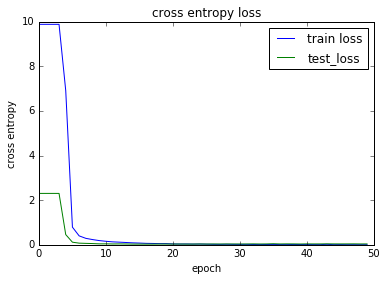

In [11]:
x = np.arange(50)
plt.plot(x, trn_loss_list)
plt.plot(x, test_loss_list)
plt.title("cross entropy loss")
plt.legend(["train loss", "test_loss"])
plt.xlabel("epoch")
plt.ylabel("cross entropy")

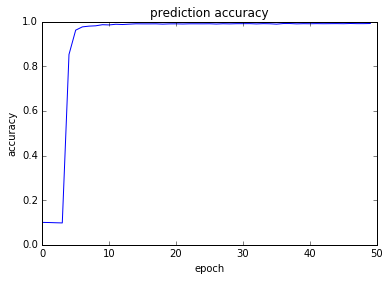

In [12]:
x = np.arange(50)
plt.plot(x, test_accuracy_list)
plt.title("prediction accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")